In [ ]:
!pip -q install mat73
!pip -q install geopandas
!pip -q install geojson

In [ ]:
import os
import mat73
import geojson
from time import sleep
from tqdm import tqdm

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler

from keras.models import Model, load_model
from keras.layers import Input, Dense, LSTM, RepeatVector, TimeDistributed
from keras import regularizers

from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

In [ ]:
base_path = '/content/drive/MyDrive/SeonwooKim GSoC 2022/4_DataBases/live/'

In [ ]:
cs_path, ds1_path, ds3_path, ds2_path, ds4_path, ds7_path, ds8_path = [os.path.join(base_path, ds_path) for ds_path in os.listdir(base_path)]

In [ ]:
columns = ['channel', 'prn', 'acq_doopler_hz', 'acq_doppler_step', 'fs', 'prompt_i', 'prompt_q', 'cn0_db_hz', 'carrier_doppler_hz', 'pseudorange_m', 'rx_time']

for ds_fname in os.listdir(base_path):
  tmp_path = os.path.join(base_path, ds_fname)
  key = ds_fname.split('.')[0]
  
  tmp_df = pd.read_csv(tmp_path, header=None)
  prn_li = []
  for i in range(8):
    prn_li.append(int(tmp_df.iloc[1, 11*i+1]))
  globals()[f'{key}_dict'] = {
      int(f'{prn_li[0]}') : tmp_df.iloc[100:, 0:9].rename(columns=lambda x: columns[x%11]).iloc[:, 5:].diff().fillna(0),
      int(f'{prn_li[1]}') : tmp_df.iloc[100:, 11:20].rename(columns=lambda x: columns[x%11]).iloc[:, 5:].diff().fillna(0),
      int(f'{prn_li[2]}') : tmp_df.iloc[100:, 22:31].rename(columns=lambda x: columns[x%11]).iloc[:, 5:].diff().fillna(0),
      int(f'{prn_li[3]}') : tmp_df.iloc[100:, 33:42].rename(columns=lambda x: columns[x%11]).iloc[:, 5:].diff().fillna(0),
      int(f'{prn_li[4]}') : tmp_df.iloc[100:, 44:53].rename(columns=lambda x: columns[x%11]).iloc[:, 5:].diff().fillna(0),
      int(f'{prn_li[5]}') : tmp_df.iloc[100:, 55:64].rename(columns=lambda x: columns[x%11]).iloc[:, 5:].diff().fillna(0),
      int(f'{prn_li[6]}') : tmp_df.iloc[100:, 66:75].rename(columns=lambda x: columns[x%11]).iloc[:, 5:].diff().fillna(0),
      int(f'{prn_li[7]}') : tmp_df.iloc[100:, 77:86].rename(columns=lambda x: columns[x%11]).iloc[:, 5:].diff().fillna(0),
      'prn' : prn_li
  }

dicts = [cs_dict, ds1_dict, ds2_dict, ds3_dict, ds4_dict, ds7_dict, ds8_dict]

In [ ]:
cs_dict[cs_dict['prn'][0]]

,prompt_i,prompt_q,cn0_db_hz,carrier_doppler_hz
100,0.0,0.0,0.0,0.0
101,0.0,0.0,0.0,0.0
102,0.0,0.0,0.0,0.0
103,0.0,0.0,0.0,0.0
104,0.0,0.0,0.0,0.0
...,...,...,...,...
3332,0.0,0.0,0.0,0.0
3333,0.0,0.0,0.0,0.0
3334,0.0,0.0,0.0,0.0
3335,0.0,0.0,0.0,0.0


In [ ]:
def compare(ds_dict, prn, key):
  plt.figure(figsize=(16,5))
  plt.subplot(1,2,1)
  plt.title('CleanStatic')
  plt.plot(cs_dict[cs_dict['prn'][prn]][key])

  plt.subplot(1,2,2)
  plt.title('Spoofed')
  plt.plot(ds_dict[ds_dict['prn'][prn]][key])

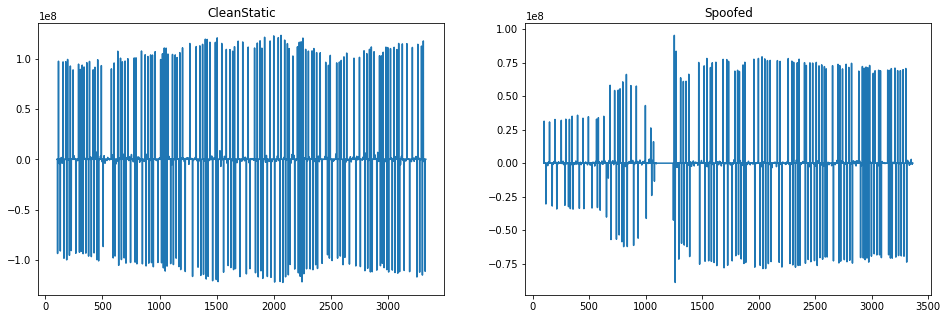

In [ ]:
compare(ds3_dict, 1, 'prompt_i')

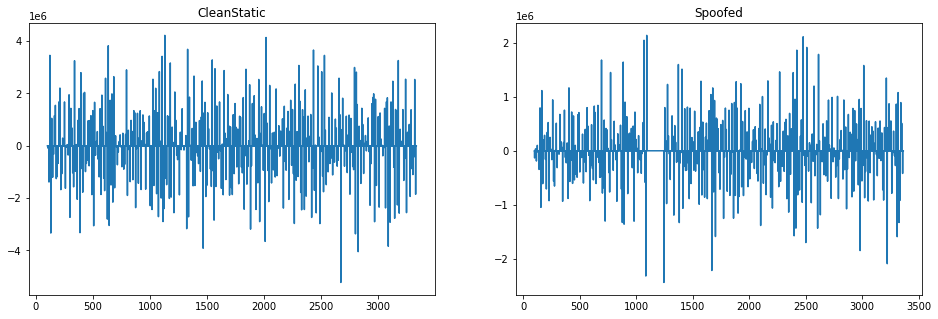

In [ ]:
compare(ds3_dict, 1, 'prompt_q')

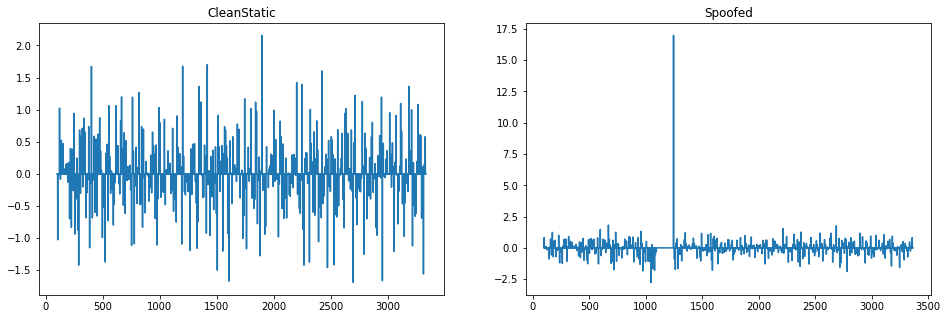

In [ ]:
compare(ds3_dict, 1, 'cn0_db_hz')

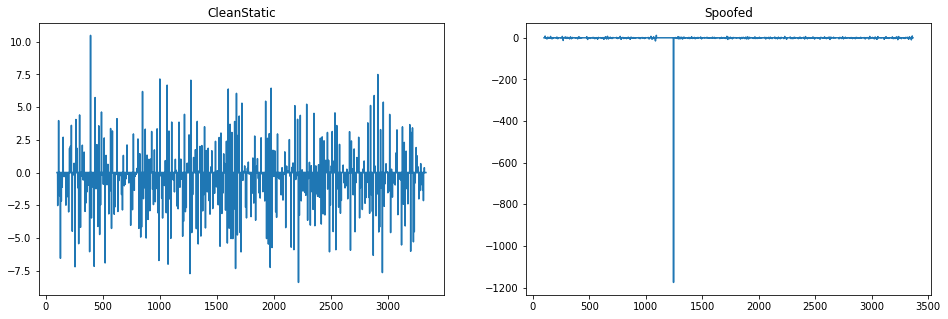

In [ ]:
compare(ds3_dict, 1, 'carrier_doppler_hz')

In [ ]:
for dic in dicts:
  for prn in list(dic.keys())[:-1]:
    df = dic[prn]
    scaler = StandardScaler()
    scaler.fit(df)
    df_scaled = scaler.transform(df)
    dic[prn] = pd.DataFrame(data=df_scaled, index=df.index, columns=df.columns)

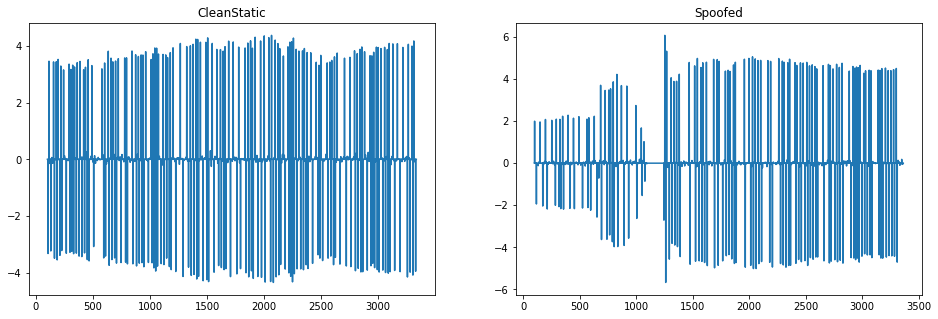

In [ ]:
compare(ds3_dict, 1, 'prompt_i')

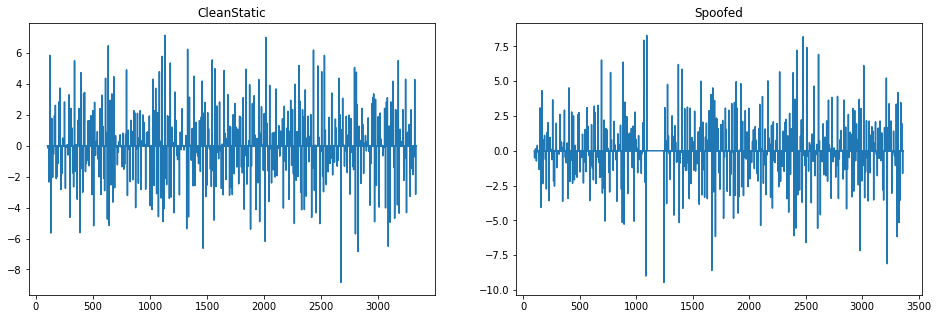

In [ ]:
compare(ds3_dict, 1, 'prompt_q')

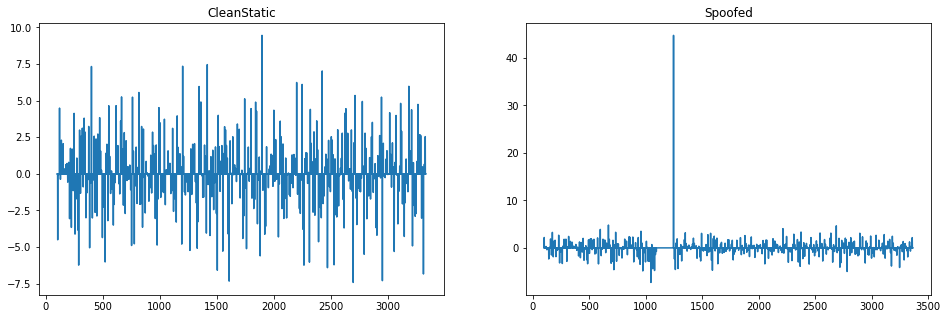

In [ ]:
compare(ds3_dict, 1, 'cn0_db_hz')

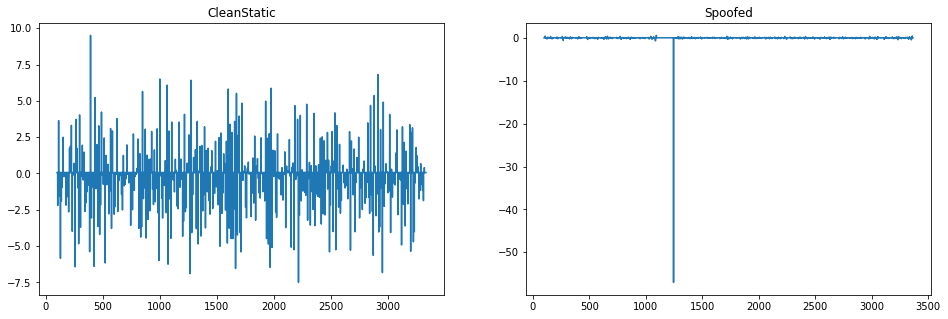

In [ ]:
compare(ds3_dict, 1, 'carrier_doppler_hz')

In [ ]:
X_train = pd.concat([cs_dict[3], cs_dict[6], cs_dict[7], cs_dict[10], cs_dict[13], cs_dict[16], cs_dict[19], cs_dict[23]]).reset_index().drop('index', axis=1)
X_train.shape

(25896, 4)

In [ ]:
X_train

,prompt_i,prompt_q,cn0_db_hz,carrier_doppler_hz
0,-0.001138,0.001133,0.000853,0.124111
1,-0.001138,0.001133,0.000853,0.124111
2,-0.001138,0.001133,0.000853,0.124111
3,-0.001138,0.001133,0.000853,0.124111
4,-0.001138,0.001133,0.000853,0.124111
...,...,...,...,...
25891,-0.000015,0.000340,-0.000699,0.117511
25892,-0.000015,0.000340,-0.000699,0.117511
25893,-0.000015,0.000340,-0.000699,0.117511
25894,-0.000015,0.000340,-0.000699,0.117511


In [ ]:
def AutoEncoder_model():
  inputs = Input(shape=(4,))
  encoder1 = Dense(3, activation='tanh')(inputs)
  encoder2 = Dense(2, activation='tanh')(encoder1)
  decoder1 = Dense(3, activation='tanh')(encoder2)
  decoder2 = Dense(4, activation='tanh')(decoder1)
  outputs = Dense(4, activation='softmax')(decoder2)
  model = Model(inputs, outputs)
  model.compile(optimizer='adam',loss='mean_squared_error')
  return model

autoencoder = AutoEncoder_model()

In [ ]:
# class AutoEncoder(tf.keras.Model):
#   def __init__(self):
#     super().__init__()
#     self.encoder = Dense(3, activation='tanh')
#     self.midlayer = Dense(2, activation='tanh')
#     self.decoder = Dense(3, activation='tanh')
#     self.decoder2 = Dense(4, activation=tf.nn.softmax)

#   def call(self, inputs):
#     x = self.encoder(inputs)
#     x = self.midlayer(x)
#     x = self.decoder(x)
#     return self.decoder2(x)

# autoencoder = AutoEncoder()

In [ ]:
# autoencoder.compile(optimizer='adam',loss='mean_squared_error')

In [ ]:
autoencoder.fit(X_train, X_train, epochs = 100, batch_size=128,
validation_data=(X_train, X_train))

Epoch 1/100
203/203 [==============================] - 3s 10ms/step - loss: 1.0353 - val_loss: 1.0116
Epoch 2/100
203/203 [==============================] - 2s 9ms/step - loss: 0.9995 - val_loss: 0.9909
Epoch 3/100
203/203 [==============================] - 2s 8ms/step - loss: 0.9857 - val_loss: 0.9807
Epoch 4/100
203/203 [==============================] - 2s 8ms/step - loss: 0.9764 - val_loss: 0.9713
Epoch 5/100
203/203 [==============================] - 2s 9ms/step - loss: 0.9649 - val_loss: 0.9590
Epoch 6/100
203/203 [==============================] - 1s 7ms/step - loss: 0.9554 - val_loss: 0.9521
Epoch 7/100
203/203 [==============================] - 1s 5ms/step - loss: 0.9491 - val_loss: 0.9458
Epoch 8/100
203/203 [==============================] - 1s 5ms/step - loss: 0.9432 - val_loss: 0.9407
Epoch 9/100
203/203 [==============================] - 1s 6ms/step - loss: 0.9390 - val_loss: 0.9373
Epoch 10/100
203/203 [==============================] - 1s 5ms/step - loss: 0.9362 - val_l

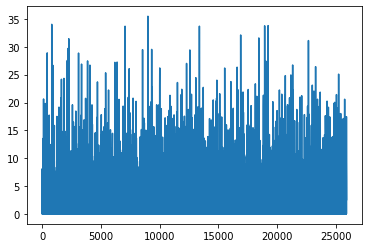

In [ ]:
X_prd = autoencoder.predict(X_train)
mse = np.mean(np.power(X_train - X_prd, 2), axis=1)
plt.plot(mse)

In [ ]:
def run_detector(ds_dict, prn, visualize=False):
  prd = autoencoder.predict(ds_dict[prn].diff().fillna(0))
  mse = np.mean(np.power(ds_dict[prn] - prd, 2), axis=1)
  if visualize:
    plt.plot(mse)
  return mse

In [ ]:
def cal_mse(dic):
  result = []
  for prn in dic['prn']:
    prd = autoencoder.predict(dic[prn])
    mse = np.mean(np.power(dic[prn] - prd, 2), axis=1)
    result.append(mse)
  return result

In [ ]:
cs_mse = cal_mse(cs_dict)
ds1_mse = cal_mse(ds1_dict)
ds2_mse = cal_mse(ds2_dict)
ds3_mse = cal_mse(ds3_dict)
ds4_mse = cal_mse(ds4_dict)
ds7_mse = cal_mse(ds7_dict)
ds8_mse = cal_mse(ds8_dict)

In [ ]:
def vis_mse(ds_mse):
  plt.figure(figsize=(20,7))
  for i in range(8):
    plt.subplot(2,4,i+1)
    plt.plot(ds_mse[i])

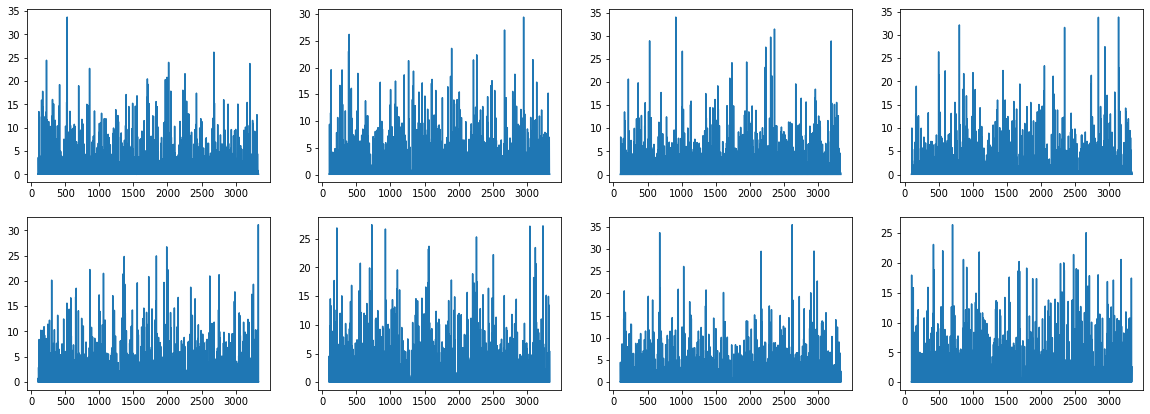

In [ ]:
vis_mse(cs_mse)

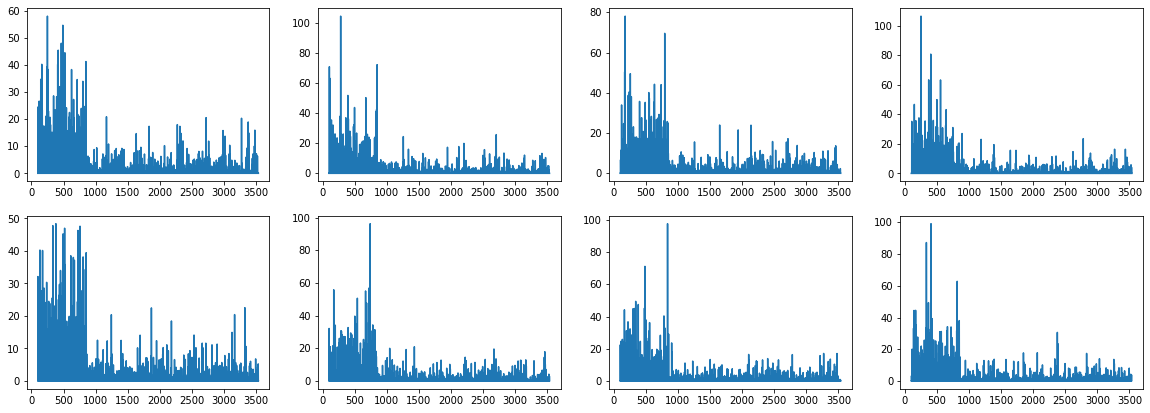

In [ ]:
vis_mse(ds1_mse)

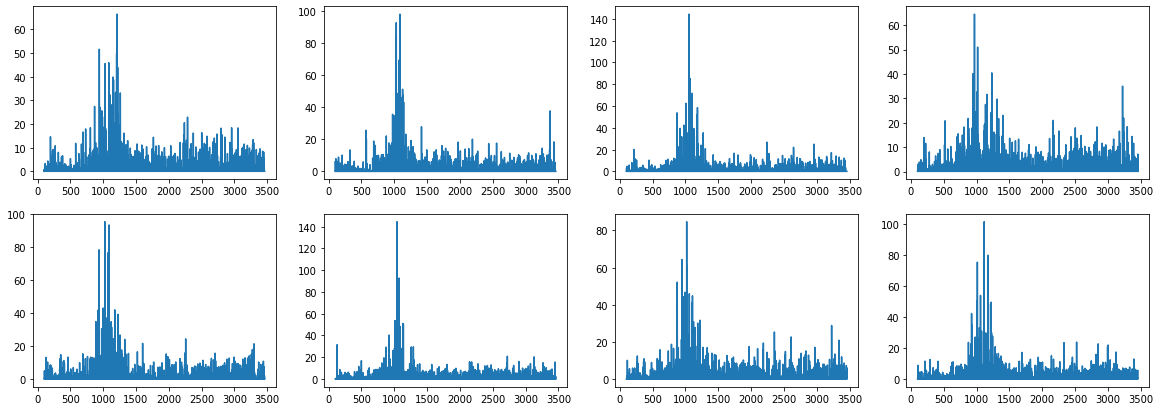

In [ ]:
vis_mse(ds2_mse)

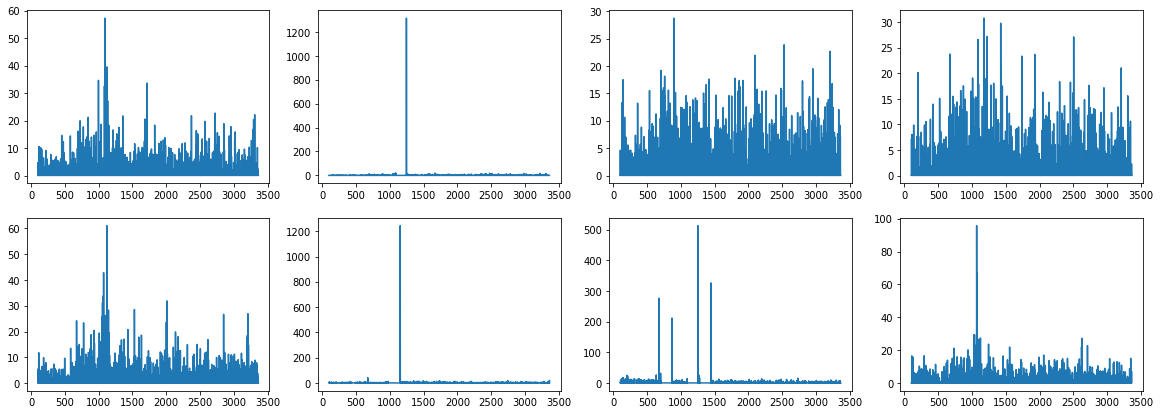

In [ ]:
vis_mse(ds3_mse)

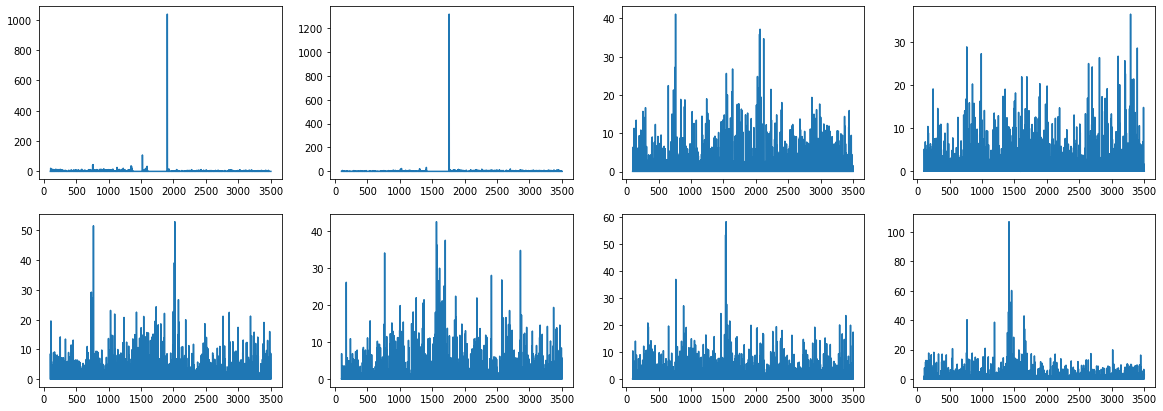

In [ ]:
vis_mse(ds4_mse)

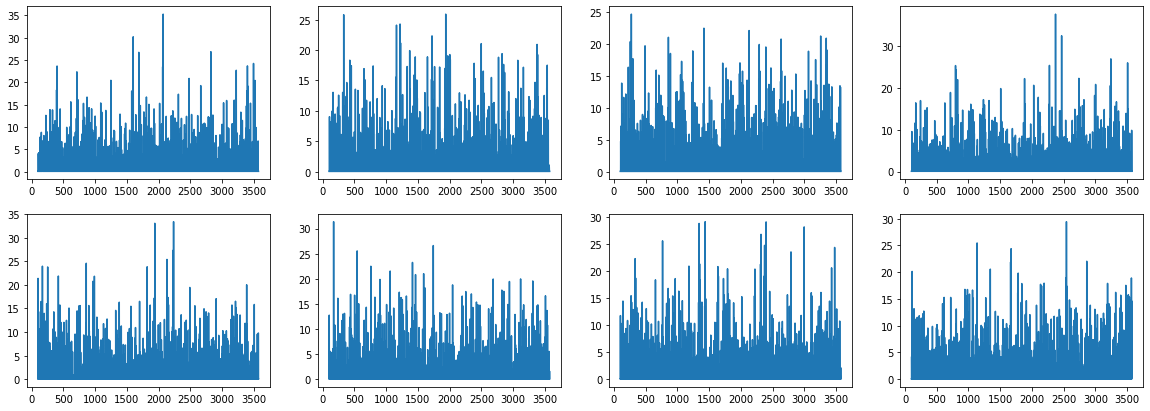

In [ ]:
vis_mse(ds7_mse)

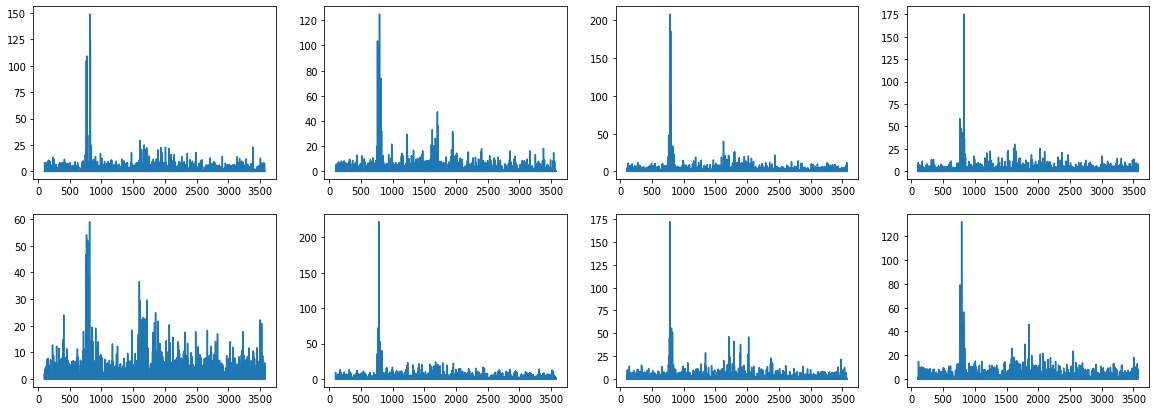

In [ ]:
vis_mse(ds8_mse)

In [ ]:
autoencoder.save('autoencoder_model')

In [ ]:
!tar -cvf autoencoder_model.tar autoencoder_model

autoencoder_model/
autoencoder_model/saved_model.pb
autoencoder_model/assets/
autoencoder_model/variables/
autoencoder_model/variables/variables.data-00000-of-00001
autoencoder_model/variables/variables.index
autoencoder_model/keras_metadata.pb


In [ ]:
model = keras.models.load_model('autoencoder_model')